In [1]:
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Build transportation grah
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(6))

# Add edges
G.add_edge(0, 1, capacity=11)
G.add_edge(0, 2, capacity=8)
G.add_edge(1, 2, capacity=10)
G.add_edge(1, 3, capacity=12)
G.add_edge(3, 2, capacity=4)
G.add_edge(2, 4, capacity=11)
G.add_edge(4, 3, capacity=7)
G.add_edge(4, 3, capacity=7)
G.add_edge(3, 5, capacity=15)
G.add_edge(4, 5, capacity=4)

# Add artificial arc
M = 1000  # Set large number
G.add_edge(5, 0, capacity=M)

In [3]:
# Note minus sign for convention
# In our formulation:
# -> 1 means arc exits node
# -> -1 means arc enters node
A = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True)
print("A =\n", A.todense())

A =
 [[ 1.  1.  0.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  1. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0. -1.  1.]]


In [4]:
# Get weights, capacities, and supply vectors
u = np.array([G[u][v]['capacity'] for u,v in G.edges])

In [5]:
# SCIPY (HIGHS) runs a simple method, which, as you know, returns exactly integral 
# solutions at vertices. Other solvers such as CLARABEL use interior-point methods 
# and they return slightly imprecise solutions that are not exactly integral.

x = cp.Variable(len(G.edges))
objective = cp.Minimize(-x[-1])
constraints = [A @ x == 0, 0 <= x, x <= u]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCIPY)
print("Optimal cost =", problem.objective.value)

Optimal cost = -19.0


In [6]:
# Show solution
print("x = ", x.value)

x =  [11.  8.  3.  8. 11. -0. 15.  7.  4. 19.]


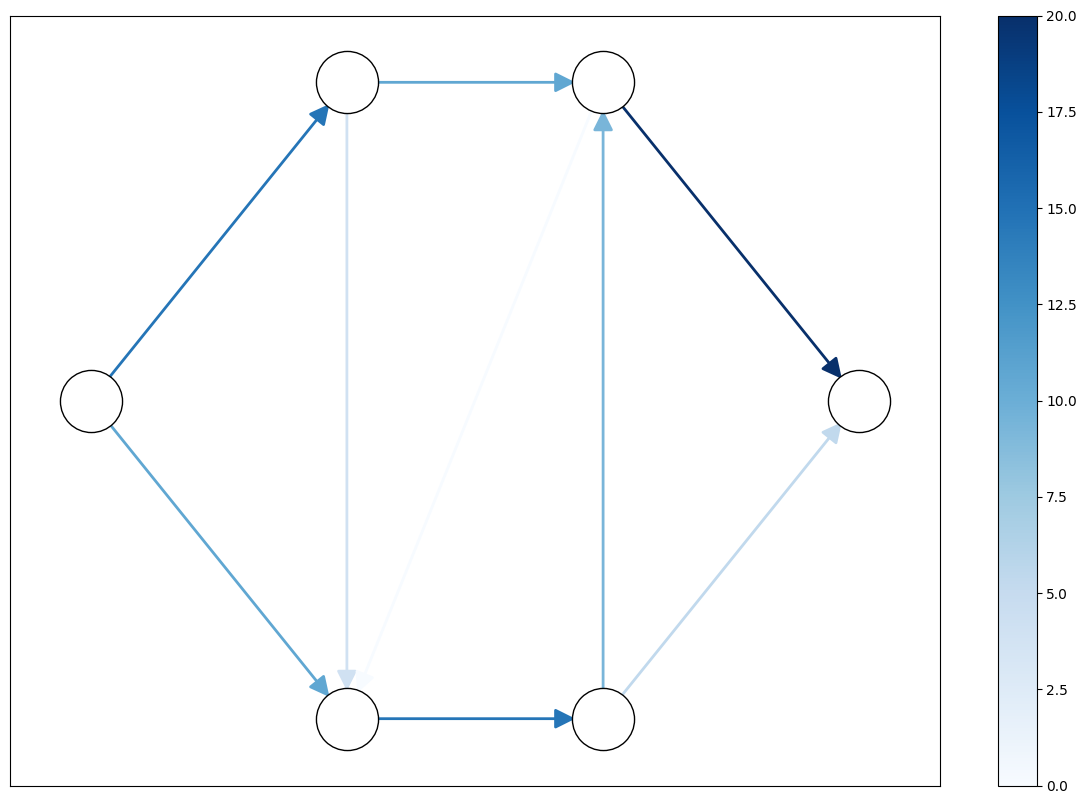

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.cm.Blues

# Node positions in 2d plot
layout = {0: np.array([0.0, 0.0]),
          1: np.array([0.5, 0.5]),
          2: np.array([0.5, -0.5]),
          3: np.array([1.0, 0.5]),
          4: np.array([1.0, -0.5]),
          5: np.array([1.5, 0.0]),
         }
nx.draw_networkx_nodes(G, layout, node_color='w', edgecolors='k', node_size=2000)

# Draw edges
edges_to_draw = [edge for edge in G.edges() if not edge == (5, 0)]
edge_values = x.value[:-1]
nx.draw_networkx_edges(G, layout, edgelist=edges_to_draw, edge_cmap=cmap, edge_color=edge_values, 
                       width=2, arrowsize=30, min_target_margin=20)

# Print colormap
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=20)
                          )
cbar = plt.colorbar(sm, ax=plt.gca())

plt.show()